In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_spd_matrix  #to generate covariance matrices

seed = 123
np.random.seed(seed)

# Switching Linear Dynamical Systems

## 2 layers Switching linear dynamical systems

At each time $t$, our model has a *discrete latent state* $z_t$ that follows Markovian dynamics with a given Markov transition matrix $\{\pi_k\}_{k=0}^{K-1} $:

$$
z_t\in \{0,2,\dots,K-1\} \\
z_{t+1} | z_t, \{\pi_k\}_{k=0}^{K-1} \sim \pi_{z_t}
$$

where $\pi_{z_t}$ is the probability distribution for the next state, i.e. the $z_t$ th row of $\{\pi_k\}_{k=0}^{K-1}$.

The discrete state $z_t$ decides which parameters to use for the dynamics of the continuous variable. 
In this notebook we consider no other hidden varaiable apart from $z_t$.
Thus $x_t$ is the *continuous state* and the *observable* of $M$ variables that follows the conditionally linear dynamic:

$$
x_{t+1} = A_{z_{t+1}} x_t + b_{z_{t+1}} +v_t \\
v_t \overset{\text{iid}}{\sim} \mathcal{N}(0,Q_{z_{t+1}})
$$

With covariance matrix $Q_{z_{t+1}}\in \mathbb{R}^{M\times M}$, coefficients matrix $A_{z_{t+1}}\in \mathbb{R}^{M\times M}$, and vector $b_{z_{t+1}}\in \mathbb{R}^{M}$ all depending on the state $z$.

In total, we have

$$
\theta = \{ ( \pi_k,A_k,Q_k,b_k) \}_{k=1}^K
$$

parameters.


In [28]:
# number of discrete states
K=3

# number of observable variables (coordinates of a 2-D motion)
M = 2

# transition matrix, KxK
pi = np.array([
    [0.25,0.5,0.25],
    [0.1,0.1,0.8],
    [0.6,0.2,0.2]
])

# generate some random A,b and Q

A = np.random.randn(K,M,M)
b = np.random.randn(K,M)
Q = np.array([make_spd_matrix(M, random_state = seed) for k in np.arange(K)])

# Generating trajectories

In [98]:
#number of samples you want to generate
N_samples = 10

#initializing the k variable as 0, z ranges from 0 to K-1
p_z0 = np.zeros(K)
p_z0[0] = 1
prob = p_z0

#initializing the x time-serie
x_serie = np.zeros((M,N_samples))

for n in np.arange(N_samples - 1):
    
    #update variable z
    prob = pi.T @ prob
    z_sampled = np.random.choice(K,p=prob)
    
    #drawing noise from a normal
    noise = np.random.multivariate_normal(mean = np.zeros(M), cov = Q[z_sampled], size = 1)

    x_serie[:,n + 1] = A[z_sampled] @ x_serie[:,n] + noise.flatten()   

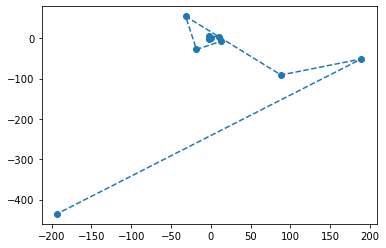

In [99]:
#è giusto?
plt.plot(x_serie[0,:], x_serie[1,:], marker = 'o', linestyle = '--')

## Recurrent Switching State Space Models

But in this model, there is no dependency on the state space; the next state probability $P(z_{t+1})$ is a Markovian *open loop* (???), i.e. it only depends on the current state $z_{t}$. But we want a dependency on the state space as well, and to capture that, we let the transition depend on additional covariates, in particular the latent variable state $x_t$:

$$
z_{t+1} | z_t,x_t,{R_k,r_k} \sim \pi_{SB} (\nu_{t+1}) \\
v_{t+1} = R_{z_t}x_t + r_{z_t}
$$

where $\pi_{SB}$ is a stick breaking logistic regression.

Unlike the standard multiclass logistic regression, which uses the softmax link function (the logistic function), here we use a _stick breaking link function_

$$
\pi_{SB} : \mathbb{R}^{K-1} \to [0,1]^{K}
$$

which maps a real vector ($\nu$) to a normalized probability vector via the stick breaking process:

$$
\pi_{SB}(\nu) = (\pi_{SB}^{(1)}(\nu),\dots,\pi_{SB}^{(K)}(\nu)) \\
\pi_{SB}^{(k)}(\nu) = \sigma(\nu_k) \prod_{j<k} (1-\sigma(\nu_j))=\sigma(\nu_k) \prod_{j<k} \sigma(\nu_j)
$$

for $k=1,2,\dots,K-1$ and $\pi_{SB}^{(K)}(\nu) = \prod_{k=1}^K \sigma(-\nu_k)$, where $\sigma(x)=e^x /(1+e^x)$ is the logistic function.

Note that the $\nu_k$ are the hyperplanes obtained from $R$ and $r$, and the $\pi_{SB}$ iteratively "chops off" parts of the state space by combining logistic regressions.


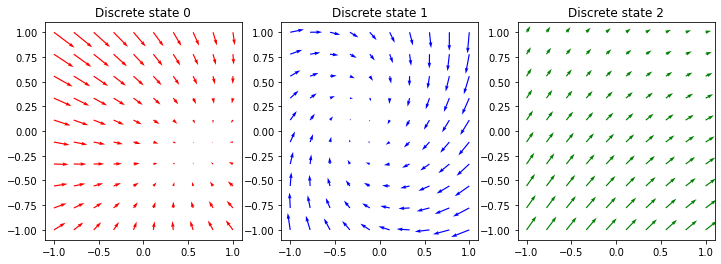

In [29]:
# plot the dynamics
fig,axs=plt.subplots(1,K,figsize=[12,4])
colors = ['red','blue','green']

# create the grid over X1 and X2
res = 10
X1 = np.linspace(-1,1,res) # is a vector of X1, dimension 10
X2 = np.linspace(-1,1,res) # is a vector of X2, dimension 10
X1,X2 = np.meshgrid(X1,X2)
X1,X2 = X1.flatten(),X2.flatten()
X = np.vstack((X1,X2))


for k in range(K):

    # now X is a vector of (M,res**2) dimension (2, 100)
    X_next = A[k] @ X + b[k].reshape(-1,1) #X_next a is the coordinates of all the 100 hundred next points
    arrows = X_next - X

    axs[k].quiver(X[0],X[1],arrows[0],arrows[1],color=colors[k])
    axs[k].set_title('Discrete state '+str(k))